In [1]:
# import modules

import fitsio 
import numpy as np 
from astropy.table import Table,vstack
from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.projections import get_projection_names
from astropy.coordinates import ICRS
from desiutil.plots import prepare_data, init_sky, plot_grid_map, plot_healpix_map, plot_sky_circles, plot_sky_binned

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

import glob

import os

* Fuji catalogs /desi/spectro/fastspecfit/fuji/catalogs/     https://data.desi.lbl.gov/desi/spectro/fastspecfit/fuji/catalogs/
* Guadalupe catalogs /desi/spectro/fastspecfit/guadalupe/catalogs/     https://data.desi.lbl.gov/desi/spectro/fastspecfit/guadalupe/catalogs/
* FastSpec Data Model https://fastspecfit.readthedocs.io/en/latest/fastspec.html#hdu01

# Read Files, and Target Selection Functions

In [5]:
# use fuji and guadalupe datasets

def read_fastspec_files(specprod=str,bd='dark'):
    ''' read in bright or dark fastspec catalogs, return the meta data and fastspec data '''
    
    specprod_dir = f'/global/cfs/cdirs/desi/spectro/fastspecfit/{specprod}/catalogs/'
    fits = glob.glob(os.path.join(specprod_dir,f'fastspec-{specprod}-*-{bd}.fits'))
    
    meta = []
    fast = []
    for file in fits:
        print(f'Reading {file}')
        f1 = Table(fitsio.read(file,'METADATA'))
        f2 = Table(fitsio.read(file,'FASTSPEC'))
        meta.append(f1)
        fast.append(f2)
        
    meta = vstack(meta)
    fast = vstack(fast)
    
    return meta, fast

def read_files(specprod='fuji',bd = 'dark',survey='sv3'):
    '''read in a single fastspec file'''
    
    file = f'/global/cfs/cdirs/desi/spectro/fastspecfit/{specprod}/catalogs/fastspec-{specprod}-{sv}-{bd}.fits'
    print(f'Reading {file}')
    f1 = Table(fitsio.read(file,'METADATA'))
    f2 = Table(fitsio.read(file,'FASTSPEC'))
    return f1, f2

def read_one_survey(specprod='fuji',survey='sv3'):
    '''read in a single fastspec file'''
    
    file = f'/global/cfs/cdirs/desi/spectro/fastspecfit/{specprod}/catalogs/fastspec-{specprod}-{survey}-dark.fits'
    print(f'Reading {file}')
    f1 = Table(fitsio.read(file,'METADATA'))
    f2 = Table(fitsio.read(file,'FASTSPEC'))
    return f1, f2

def read_file(specprod='fuji'):
    '''read in a single fastspec file'''
    
    file = f'/global/cfs/cdirs/desi/spectro/fastspecfit/{specprod}/catalogs/fastspec-{specprod}.fits'
    print(f'Reading {file}')
    f1 = Table(fitsio.read(file,'METADATA'))
    f2 = Table(fitsio.read(file,'FASTSPEC'))
    return f1, f2
    

In [6]:
#%time fuji_meta,fuji_fast = read_files(specprod='fuji',bd = 'dark',sv='sv3')
# read in dark fuji data
#%time meta_fuji,fast_fuji = read_fastspec_files(specprod='fuji',bd='dark')


%time fuji_meta,fuji_fast = read_one_survey(specprod='fuji',survey='sv3')

Reading /global/cfs/cdirs/desi/spectro/fastspecfit/fuji/catalogs/fastspec-fuji-sv3-dark.fits
CPU times: user 16 s, sys: 6.25 s, total: 22.2 s
Wall time: 44.1 s


In [4]:
# read in dark guadalupe data
%time guad_meta,guad_fast = read_file(specprod='guadalupe')

Reading /global/cfs/cdirs/desi/spectro/fastspecfit/guadalupe/catalogs/fastspec-guadalupe.fits
CPU times: user 1min 11s, sys: 34.6 s, total: 1min 45s
Wall time: 2min 55s


In [7]:
# pick indices with ELGs and ZWARN = 0
def pick_ELG(meta,sv3=False,zmin=0.5,zmax=1.6):
    ''' pick targets that are ELGs '''
    
    
    if sv3 == False: # if fuji sv3 = True
        ielg = meta['DESI_TARGET'] & desi_mask.ELG != 0
    else:
        ielg = meta['SV3_DESI_TARGET'] & desi_mask.ELG != 0
    
    zwarn = meta['ZWARN'] == 0

    zrange = (meta['Z'] > zmin) * (meta['Z'] < zmax)

    indx = np.where(ielg * zwarn * zrange)[0]
    
    print(f'Number of ELGs {np.sum(ielg)}')
    print(f'Number of good ELGs {np.sum(ielg * zwarn)} (ZWARN == 0)')
    print(f'Number of good ELGs in redshift range {np.sum(ielg * zwarn * zrange)} (ZWARN == 0 & zmin,zmax)')
    return indx

In [8]:
def match_indices(arr1,arr2):
    '''return an array of matching elements from two arrays'''
    
    match = np.intersect1d(arr1,arr2)
    print(f'Matched indices {len(match)}')
    return match

In [9]:
# pick elgs with a signal to noise ratio (S/N) > 3 of various doublets
# Amp*sqrt(amp_ivar)

def doublet_snr_targets(fast,element,idx,snr=3):
    ''' choose an initial target index and element to pick targets with an acceptable SNR of OII, SII, and MGII doublets '''
        
    if element == 'OII':
        snr1 = fast['OII_3726_AMP'][idx]*np.sqrt(fast['OII_3726_AMP_IVAR'][idx])
        snr2 = fast['OII_3729_AMP'][idx]*np.sqrt(fast['OII_3729_AMP_IVAR'][idx])

        db1 = np.where(snr1 > snr)[0]
        db2 = np.where(snr2 > snr)[0]
        
        print(f'Number of good [OII] 3726 lines {len(db1)}')
        print(f'Number of good [OII] 3729 lines {len(db2)}')
        return db1,db2

    elif element == 'MGII':
        snr1 = fast['MGII_2796_AMP'][idx]*np.sqrt(fast['MGII_2803_AMP_IVAR'][idx])
        snr2 = fast['MGII_2796_AMP'][idx]*np.sqrt(fast['MGII_2803_AMP_IVAR'][idx])

        db1 = np.where(snr1 > snr)[0]
        db2 = np.where(snr2 > snr)[0]
        
        print(f'Number of good [MGII] 2796 lines {len(db1)}')
        print(f'Number of good [MGII] 2803 lines {len(db2)}')
        return db1,db2

    elif element == 'SII':
        snr1 = fast['SII_6731_AMP'][idx]*np.sqrt(fast['SII_6716_AMP_IVAR'][idx])
        snr2 = fast['SII_6731_AMP'][idx]*np.sqrt(fast['SII_6716_AMP_IVAR'][idx])

        db1 = np.where(snr1 > snr)[0]
        db2 = np.where(snr2 > snr)[0]
        
        print(f'Number of good [SII] 6731 lines {len(db1)}')
        print(f'Number of good [SII] 6716 lines {len(db2)}')
        return db1,db2
    
def snr_single_target(amp,amp_ivar, snr = 3):
    ''' return array of indices with a desired signal to noise ratio '''
    
    isnr = np.where(amp*np.sqrt(amp_ivar) > snr)[0]
    return isnr

In [10]:
def doublet_ra_dec(meta,idx1,idx2,oii=False,sii=False,mgii=False):
    ''' plot ra and dec of OII, SII, and MGII doublets '''
    
    if oii == True:
        ax = init_sky(projection='aitoff',ra_center=90,galactic_plane_color='red')
        p = ax.scatter(meta['RA'][idx1], meta['DEC'][idx1], marker='.',label='$\lambda$3726')
        p = ax.scatter(meta['RA'][idx2], meta['DEC'][idx2], marker='.',alpha=0.3,label='$\lambda$3729')
        plt.show()
        
    if sii == True:
        ax = init_sky(projection='aitoff',ra_center=90,galactic_plane_color='red')
        p = ax.scatter(meta['RA'][idx1], meta['DEC'][idx1], marker='.',label='$\lambda$6731')
        p = ax.scatter(meta['RA'][idx2], meta['DEC'][idx2], marker='.',alpha=0.3,label='$\lambda$6716')
        plt.show()
        
    if mgii == True:
        ax = init_sky(projection='aitoff',ra_center=90,galactic_plane_color='red')
        p = ax.scatter(meta['RA'][idx1], meta['DEC'][idx1], marker='.',label='$\lambda$2796')
        p = ax.scatter(meta['RA'][idx2], meta['DEC'][idx2], marker='.',alpha=0.3,label='$\lambda$2803')
        plt.show()

In [89]:
def all_sky_plot(meta,matches):
    ''' all sky plot of selected targets'''
    ax = init_sky(projection='aitoff',ra_center=90,galactic_plane_color='red')
    p = ax.scatter(meta['RA'][matches], meta['DEC'][matches], marker='.',c=meta['Z'][matches],cmap='plasma')
    plt.colorbar(p,label='Redshift')
    plt.show()
    
def zhist(meta,idx):
    ''' create a histogram of redshifts with inputted data '''
    fig,ax = plt.subplots()
    _ = ax.hist(meta['Z'][idx],bins=50,color='blue')
    ax.set_xlabel('Redshift (Z)')
    fig.show()

# Fuji

In [22]:
fielgs = pick_ELG(fuji_meta,sv3=True)

Number of ELGs 392588
Number of good ELGs 330435 (ZWARN == 0)
Number of good ELGs in redshift range 285705 (ZWARN == 0 & zmin,zmax)


In [23]:
# oii doesnt match, but sii and mgii seem to be the same indices
foii3726, foii3729 = doublet_snr_targets(fuji_fast,'OII',fielgs)
#sii6731, sii6716 = doublet_snr_targets('SII',ielgs)
#mgii2796, mgii2803 = doublet_snr_targets('MGII',ielgs)

Number of good [OII] 3726 lines 202017
Number of good [OII] 3729 lines 238850


In [24]:
foii_match = match_indices(foii3726,foii3729)
#sii_match = match_indices(sii6731,sii6716)
#mgii_match = match_indices(mgii2796,mgii2803)

#doublets = [oii_match,sii_match,mgii_match]
#all_match = match_all(doublets)

Matched indices 192445


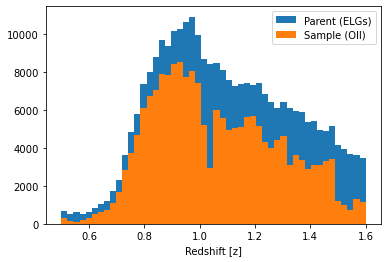

In [111]:
fuji_z = fuji_meta['Z'][fielgs][foii_match]

fz = fuji_meta['Z'][fielgs]

fig,ax = plt.subplots()
_ = ax.hist(fz,bins = 50,label = 'Parent (ELGs)')
_ = ax.hist(fuji_z,bins=50, label = 'Sample (OII)')
ax.set_xlabel('Redshift [z]')
ax.legend()
fig.show()

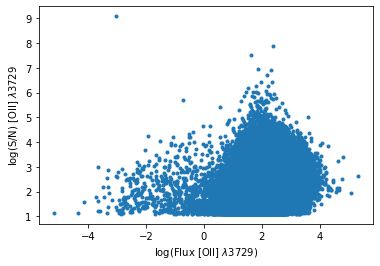

In [107]:
# snr vs log(flux) of 3729

flogflux = np.log(fuji_fast['OII_3729_FLUX'][fielgs][foii3729])
fsnr = np.log(fuji_fast['OII_3729_AMP'][fielgs][foii3729]*np.sqrt(fuji_fast['OII_3729_AMP_IVAR'][fielgs][foii3729]))

fig, ax = plt.subplots()
_ = ax.plot(flogflux,fsnr,'.')
ax.set_xlabel('log(Flux [OII] $\lambda$3729)')
ax.set_ylabel('log(S/N) [OII] $\lambda$3729')
fig.show()

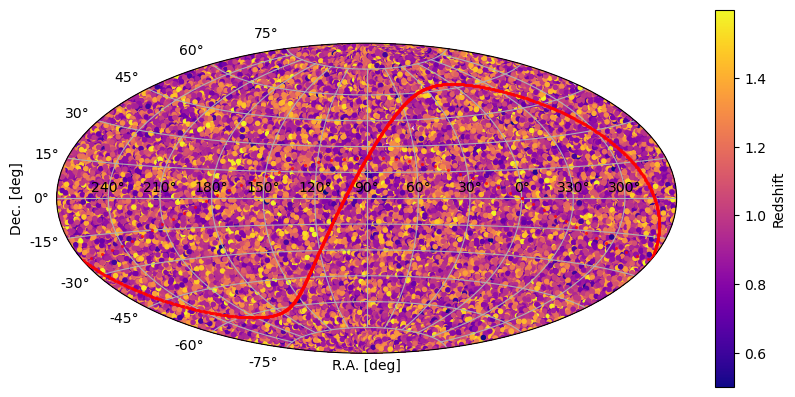

In [90]:
all_sky_plot(fuji_meta[fielgs],foii_match)

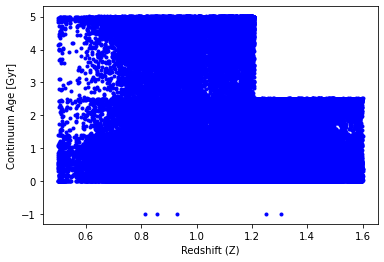

In [82]:
fage = fuji_fast['CONTINUUM_AGE'][fielgs][foii_match]
fuji_z = fuji_meta['Z'][fielgs][foii_match]

fig,ax = plt.subplots()

ax.plot(fuji_z,fage,'b.')
#ax.set_xlim(0,1.65)
#ax.set_ylim(0.4,1.6)
ax.set_ylabel('Continuum Age [Gyr]')
ax.set_xlabel('Redshift (Z)')
fig.show()

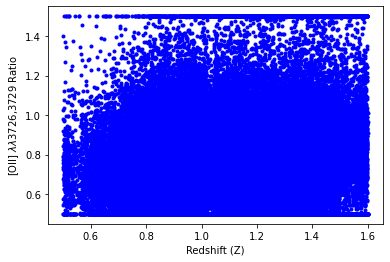

In [83]:
foii_ratio = fuji_fast['OII_DOUBLET_RATIO'][fielgs][foii_match]
fuji_z = fuji_meta['Z'][fielgs][foii_match]

fig,ax = plt.subplots()

ax.plot(fuji_z,foii_ratio,'b.')
ax.set_ylabel('[OII] $\lambda\lambda$3726,3729 Ratio')
ax.set_xlabel('Redshift (Z)')
fig.show()

# Guadalupe

In [ ]:
#meta_guad.columns

In [31]:
gielgs = pick_ELG(guad_meta)

Number of ELGs 499457
Number of good ELGs 407073 (ZWARN == 0)
Number of good ELGs in redshift range 301023 (ZWARN == 0 & zmin,zmax)


In [32]:
goii3726, goii3729 = doublet_snr_targets(guad_fast,'OII',gielgs)

Number of good [OII] 3726 lines 190176
Number of good [OII] 3729 lines 228732


In [33]:
goii_match = match_indices(goii3726,goii3729)

Matched indices 179205


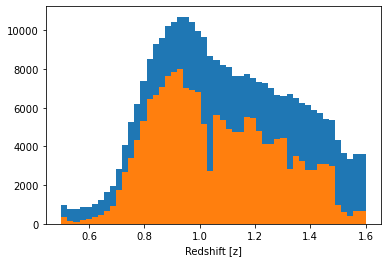

In [112]:
guad_z = guad_meta['Z'][gielgs][goii_match]

gz = guad_meta['Z'][gielgs]

fig,ax = plt.subplots()
_ = ax.hist(gz,bins = 50, label = 'Parent (ELGs)') # parent
_ = ax.hist(guad_z,bins=50, label = 'Sample (OII)') # sample
ax.set_xlabel('Redshift [z]')
fig.show()

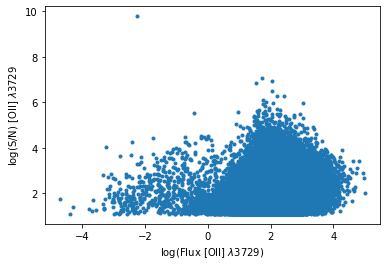

In [108]:
glogflux = np.log(guad_fast['OII_3729_FLUX'][gielgs][goii3729])
gsnr = np.log(guad_fast['OII_3729_AMP'][gielgs][goii3729]*np.sqrt(guad_fast['OII_3729_AMP_IVAR'][gielgs][goii3729]))

fig, ax = plt.subplots()
_ = ax.plot(glogflux,gsnr,'.')
ax.set_xlabel('log(Flux [OII] $\lambda$3729)')
ax.set_ylabel('log(S/N) [OII] $\lambda$3729')
fig.show()

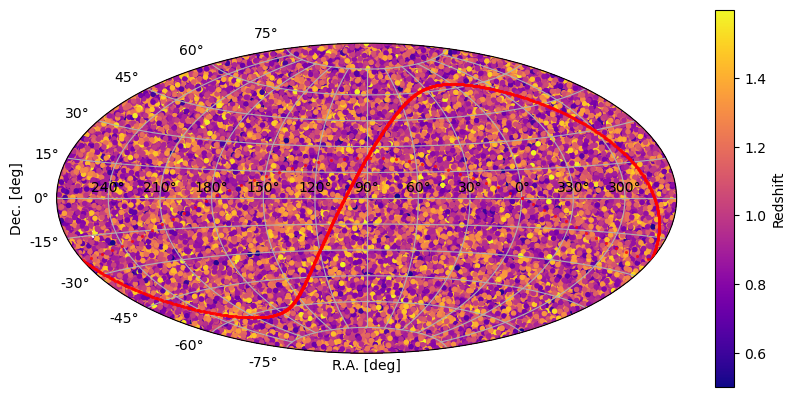

In [109]:
all_sky_plot(guad_meta[gielgs],goii_match)

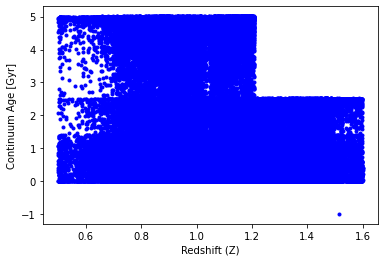

In [84]:
g_age = guad_fast['CONTINUUM_AGE'][gielgs][goii_match]
guad_z = guad_meta['Z'][gielgs][goii_match]

fig,ax = plt.subplots()

ax.plot(guad_z,g_age,'b.')
ax.set_ylabel('Continuum Age [Gyr]')
ax.set_xlabel('Redshift (Z)')
fig.show()

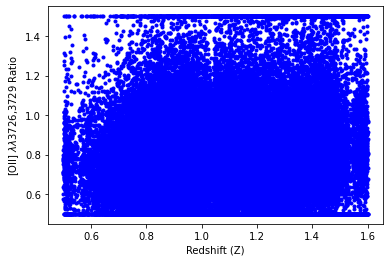

In [86]:
goii_ratio = guad_fast['OII_DOUBLET_RATIO'][gielgs][goii_match]
guad_z = guad_meta['Z'][gielgs][goii_match]

fig,ax = plt.subplots()

ax.plot(guad_z,goii_ratio,'b.')
ax.set_ylabel('[OII] $\lambda\lambda$3726,3729 Ratio')
ax.set_xlabel('Redshift (Z)')
fig.show()